In [283]:
import os

import glob
import fitsio

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits as fits

import desispec.io
import redrock.templates
import matplotlib.pyplot as plt

from   desisim.specsim          import  get_simulator
from   astropy.convolution      import  convolve, Box1DKernel
from   desispec.spectra         import  Spectra
from   desispec.resolution      import  Resolution

from   desispec.interpolation   import  resample_flux

from   astropy.table            import  Table
from   desispec.io.image        import  read_image

from   specter.psf.gausshermite import GaussHermitePSF
from   scipy.signal             import medfilt

# Foundations to 1004 desispec ticket:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

In [339]:
#  andes                  = '/global/cfs/cdirs/desi/spectro/redux/andes/'
andes                     = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes'

os.environ['SPEC_PROD']   = andes

# os.environ['DESIMODEL'] = '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.13.0' 
os.environ['DESIMODEL']   = '/global/scratch/mjwilson/miniconda3/envs/desi/code/desimodel'

os.environ['DESI_BASIS_TEMPLATES'] = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/templates/basis_templates/v3.1/'

os.environ['RESULTS']     = '/global/scratch/mjwilson'

# Get a cframe for ELG SV0 tile (67230)

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

In [243]:
night      = '20200314'

tile       = 67230
petal      = 0

# 0th fiber in the petal.
fiber      = 0

# Get (calibrated) spectra and calibration data 

In [244]:
# For each camera.
frames     = {}
cframes    = {}

psfs       = {}
skies      = {} 

fluxcalibs = {}

for cam in ['g', 'r', 'z']:
  # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/tiles/67230/20200314/cframe-z9-00055382.fits  
  specpaths    = glob.glob('{}/tiles/{}/{}/cframe-{}{}-*.fits'.format(andes, tile, night, cam, petal))

  expids       = [x.split('-')[-1].replace('.fits', '') for x in specpaths]
        
  # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/exposures/20200315/00055590/sky-r8-00055590.fits
  # skies_path   = glob.glob('{}/exposures/{}/{}/sky-{}{}-{}.fits'.format(andes, tile, night, cam, petal))
    
  mjd_obs      = 0.0
    
  for i, specpath in enumerate(specpaths):
    dat        = fits.open(specpath)
    
    _          = dat[0].header['MJD-OBS']

    # Get the last in the night, for example.      
    if _ > mjd_obs:          
        cframes[cam]    = fitsio.FITS(specpath)
                
        expid           = expids[i]
        exptime         = dat[0].header['EXPTIME']
        
        fiberid         = cframes[cam]['FIBERMAP']['FIBER'][fiber]
        
        psfs[cam]       = fitsio.FITS('{}/exposures/{}/{}/psf-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        skies[cam]      = fitsio.FITS('{}/exposures/{}/{}/sky-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        # https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_CALIB/fluxcalib-CAMERA.html
        fluxcalibs[cam] = fitsio.FITS('{}/exposures/{}/{}/fluxcalib-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        frames[cam]     = fitsio.FITS('{}/exposures/{}/{}/frame-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        mjd_obs         = dat[0].header['MJD-OBS']

In [245]:
print(night, tile, expid, exptime, fiberid)

20200314 67230 00055382 900.0 0


# Get GFA data

In [246]:
def get_med_gfa(printit=False, root='/global/scratch/mjwilson'):
  gfa = Table.read(root + '/offline_all_guide_ccds_SV0.fits')
    
  gfa = gfa[gfa['SPECTRO_EXPID'] > -1]
  gfa = gfa[gfa['N_SOURCES_FOR_PSF'] > 2]
  gfa = gfa[gfa['CONTRAST'] > 2]
  gfa = gfa[gfa['NPIX_BAD_TOTAL'] < 10]

  gfa.sort('SPECTRO_EXPID')

  gfa = gfa['SPECTRO_EXPID', 'FWHM_ASEC', 'TRANSPARENCY', 'FIBER_FRACFLUX', 'SKY_MAG_AB', 'MJD']
    
  by_spectro_expid = gfa.group_by('SPECTRO_EXPID')

  # gfa_mean = by_spectro_expid.groups.aggregate(np.mean)
  gfa_median = by_spectro_expid.groups.aggregate(np.median)
 
  if printit:
    print(gfa_median)

  return  gfa_median

In [247]:
med_gfa    = get_med_gfa()

In [248]:
med_gfa

SPECTRO_EXPID,FWHM_ASEC,TRANSPARENCY,FIBER_FRACFLUX,SKY_MAG_AB,MJD
int32,float64,float64,float64,float64,float64
55353,1.3556690883636473,0.9491531856658579,0.42902994928339766,20.13257532857953,58923.105804845
55354,1.0842609405517578,0.9306584084094406,0.5758220848678852,20.716475970074487,58923.11684792
55355,1.1528374147415161,0.9287752724595781,0.5266150665431396,20.751343417592672,58923.12406566
55356,1.124827275276184,0.9291547576080916,0.5513398270660941,20.78339337676281,58923.1282444
55357,1.1412470054626465,0.9324662058076588,0.5494354959155627,20.736887796902987,58923.13247917
55358,1.0398310708999634,0.926993168397129,0.6079540155317155,20.732981448479244,58923.13667283
55359,1.3305566978454588,0.8911601509977743,0.42628248906121285,20.784752835872254,58923.14101085
55360,1.248458046913147,0.9177696043867326,0.47084553982027816,20.80443171895309,58923.14525603
55361,1.1383494520187378,0.8861931873134048,0.5298523127713594,20.773264489657137,58923.14950753


In [249]:
exp_gfa = med_gfa[med_gfa['SPECTRO_EXPID'] == expid]

In [250]:
exp_gfa

SPECTRO_EXPID,FWHM_ASEC,TRANSPARENCY,FIBER_FRACFLUX,SKY_MAG_AB,MJD
int32,float64,float64,float64,float64,float64
55353,1.3556690883636473,0.9491531856658579,0.42902994928339766,20.13257532857953,58923.105804845


In [251]:
FIBERLOSS = exp_gfa['FIBER_FRACFLUX']

# Get 2D PSF and define NPIX

Expectation of 3.44 for PSF size in pixel units (spectro paper).

In [252]:
fname = andes + '/calibnight/{}/psfnight-{}{}-{}.fits'.format(night, camera, petal, night)

In [253]:
psf = GaussHermitePSF(fname)

In [254]:
# One petal, one arm to a CCD.
psf.nspec, psf.npix_x, psf.npix_y

(500, 4114, 4128)

In [255]:
# Representative wavelength. 
wave  = 3727. * (1. + 1.1)

In [256]:
# Fiber centroid position on CCD.
# https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L467
x,y = psf.xy(fiberid, wave)
x,y

(106.5136658758136, 752.9673119771362)

In [257]:
# https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L300
# Range that boxes in fiber 'trace':  (xmin, xmax, ymin, ymax)
psf.xyrange(fiberid, wave)

(99, 116, 747, 759)

In [258]:
# Return Gaussian sigma of PSF spot in cross-dispersion direction in CCD pixel units.
#  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
#  http://www.ucolick.org/~bolte/AY257/s_n.pdf
2. * 1.7 * psf.xsigma(ispec=fiberid, wavelength=wave)

4.148481944894554

In [259]:
#  Gaussian sigma of PSF spot in dispersion direction in CCD pixel units.
#  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
#  http://www.ucolick.org/~bolte/AY257/s_n.pdf
2. * 1.7 * psf.ysigma(ispec=fiberid, wavelength=wave)

4.220916150012472

In [260]:
psf_2d = psf.pix(ispec=fiberid, wavelength=wave)
psf_2d.shape

(11, 17)

In [261]:
norm = np.sum(psf_2d); norm

0.9999999999999999

In [262]:
# http://articles.adsabs.harvard.edu/pdf/1983PASP...95..163K
NEA  = 1. / np.sum(psf_2d ** 2.) # [pixel units].
NPIX = NEA; 

print('For {}, fiber {} on camera {} for tile {}, NPIX is {}'.format(night, fiberid, camera, tile, NPIX))

For 20200314, fiber 0 on camera z for tile 67230, NPIX is 19.960498391945666


In [263]:
ANGSTROMS_PER_PIXEL = psf.angstroms_per_pixel(fiber, wave); ANGSTROMS_PER_PIXEL

0.6344665864382577

# Get (fiber local) READNOISE for this exposure.

In [154]:
image = read_image(andes + '/preproc/{}/{}/preproc-{}{}-{}.fits'.format(night, expid, camera, petal, expid))

In [155]:
image.camera

'z0'

In [156]:
(xmin, xmax, ymin, ymax) = psf.xyrange(fiber, wave)

In [157]:
# electrons/pixel (float).
rd_cutout = image.readnoise[ymin:ymax, xmin:xmax]

In [158]:
rd_cutout.shape

(11, 17)

In [159]:
rd_cutout

array([[2.6038661 , 2.61328077, 2.63635802, 2.62130785, 2.61548781,
        2.61725259, 2.61492872, 2.6206522 , 2.62121773, 2.59954309,
        2.62513161, 2.62209105, 2.6048317 , 2.6248343 , 2.61661053,
        2.61507368, 2.61460853],
       [2.63990784, 2.61200142, 2.62542319, 2.61179233, 2.59656262,
        2.62181544, 2.62189126, 2.61664772, 2.61373973, 2.61161304,
        2.60422587, 2.5987072 , 2.62767267, 2.61586118, 2.59803391,
        2.63251328, 2.60625792],
       [2.62200999, 2.61430717, 2.6329391 , 2.59141302, 2.61721706,
        2.62079883, 2.63420963, 2.58886099, 2.5689137 , 2.62649059,
        2.60988116, 2.58939624, 2.61174393, 2.60072064, 2.64164734,
        2.60800791, 2.60744572],
       [2.59281731, 2.63852024, 2.60270619, 2.61711478, 2.6382699 ,
        2.62645698, 2.61299372, 2.6017983 , 2.61044908, 2.62449098,
        2.62200904, 2.6257422 , 2.64349651, 2.67025661, 2.63041782,
        2.62693477, 2.63257837],
       [2.63035536, 2.60361147, 2.59951758, 2.619106

In [160]:
# electrons/pixel
np.median(rd_cutout), np.median(image.readnoise)

(2.615861177444458, 2.48201847076416)

In [161]:
RDNOISE = np.median(rd_cutout)

# Sky flux

_Counts is the same as electrons, or is there a gain factor?_

Text(0, 0.5, 'Counts per Angstrom')

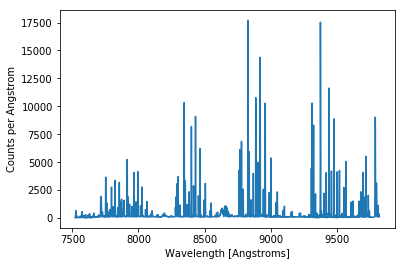

In [265]:
pl.plot(skies[camera]['WAVELENGTH'][:], skies[camera]['SKY'][0, :].T)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Counts per Angstrom')

Text(0.5, 1.0, 'Sky continuum (116.0A median filter)')

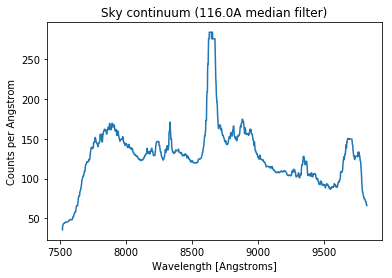

In [231]:
kernel_N      = 145
sky_continuum = medfilt(skies[camera]['SKY'][0, :][0], kernel_N)

pl.plot(skies[camera]['WAVELENGTH'][:], sky_continuum)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Counts per Angstrom')

pl.title('Sky continuum ({}A median filter)'.format(kernel_N * 0.8))

# Flux calibration

In [232]:
# Includes seeing and airmass terms (therefore fiberloss).
fluxcalib          = fluxcalibs[camera]['FLUXCALIB'][0,:]

# Calibration for no fiber loss; nominally we need this for the sky flux calib, but it's already in e/A.
lossless_fluxcalib = fluxcalib / FIBERLOSS

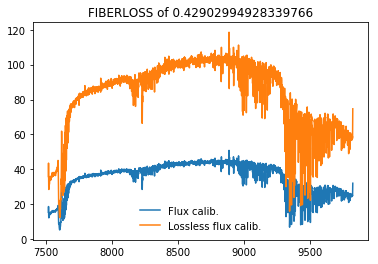

In [233]:
pl.plot(wave, fluxcalib[0],          label='Flux calib.')
pl.plot(wave, lossless_fluxcalib[0], label='Lossless flux calib.')

pl.title('FIBERLOSS of {}'.format(FIBERLOSS))

pl.legend(loc=0, frameon=False)

# Template SNR

In [235]:
FIBERTILEID = 10000 * tile + fiberid

print(tile, expid, fiberid, FIBERTILEID)

67230 00055382 0 672300000


$\Huge \langle tSNR^2 \rangle = \sum_{grz} \sum_{\lambda \in grz} \frac{\tau^2 T^2 \langle \Delta F^2 \rangle}{\sigma_e^2 \cdot {\rm NPIX} + \tau T_{\rm sky}  F_{\rm sky}}$

_"We choose to normalize it such that zSNR = 3 for a 1000 sec dark time exposure in
nominal conditions."_

Here:  
- $\sigma_e$ is the READNOISE in units of ELECTRONS / PIXEL. 
- NPIX is the projected fiber area in units of PIXELS for a width of **ONE ANGSTROM**.  
- $\Delta F$ is the residual (template) flux from a 100A filtered equivalent.
- $\tau$ is the exposure time, already included in the flux calib.
- $T_{\rm sky} F_{\rm sky}$ is the estimated fiber sky flux in units of ELECTRONS PER ANGSTROM.

In [422]:
def templateSNR(template_flux, sky_flux, flux_calib=None, flux_ivar=None):
    # dlambda per pixel = 0.8; 100A / dlambda per pixel = 125. 
    sflux  = convolve(template_flux, Box1DKernel(125)) 
 
    dflux  = template_flux - sflux 
 
    if flux_calib is None:
        # Work in calibrated flux units.
        # Assumes Poisson Variance from source is negligible.
        assert  flux_ivar is not None
        
        return  np.sum(flux_ivar * dflux ** 2.)

    else: 
        # Work in uncalibrated flux units; flux_calib includes exptime. tau.
        dflux  *= flux_calib
 
        result  = dflux * dflux

        # RDNOISE & NPIX assumed wavelength independent
        denom   = RDNOISE * NPIX / ANGSTROMS_PER_PIXEL + sky_flux
        
        result /= denom
        
        # Eqn. (1) of https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2
        return  np.sum(result)

# DESI sim. galaxy spectral templates 

TODO:  figure out fiber / fiberid indexing of arrays.

In [423]:
def tracer_maker(wave=None, tracer='ELG', nmodel=1):
    if tracer == 'ELG':
        maker = desisim.templates.ELG(wave=wave)
                
    elif tracer == 'QSO':
        maker = desisim.templates.QSO(wave=wave)
    
    else:
        raise  ValueError('{} is not an available tracer.'.format(tracer))

    flux, wave, meta, objmeta = maker.make_templates(nmodel=nmodel)
        
    return  wave, flux, meta, objmeta     

In [424]:
wave                   = cframes[camera]['WAVELENGTH'][:]
_, flux, meta, objmeta = tracer_maker(wave=wave, tracer='ELG', nmodel=10)

INFO:io.py:971:read_basis_templates: Reading /global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/templates/basis_templates/v3.1/elg_templates_v2.2.fits


/global/scratch/mjwilson/miniconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [425]:
meta['MAG_G']          = 22.5 - 2.5 * np.log10(meta['FLUX_G'])
meta['MAG_R']          = 22.5 - 2.5 * np.log10(meta['FLUX_R'])
meta['MAG_Z']          = 22.5 - 2.5 * np.log10(meta['FLUX_Z'])

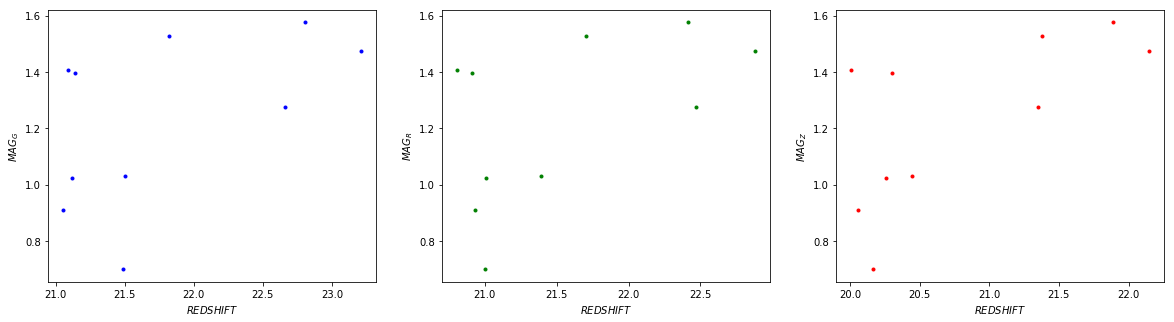

In [426]:
fig, axes              = plt.subplots(1, 3, figsize=(20, 5))

for i, (band, color) in enumerate(zip(['MAG_G', 'MAG_R', 'MAG_Z'], ['b', 'g', 'r'])):
  axes[i].plot(meta[band], meta['REDSHIFT'], marker='.', c=color, lw=0.0)

  axes[i].set_xlabel('$REDSHIFT$')
  axes[i].set_ylabel('$' + band + '$')  

In [427]:
fflux                  = flux[:, :]
flux_ivar              = np.tile(cframes[camera]['IVAR'][0, :], (len(fflux), 1))

res                    = np.tile(cframes[camera]['RESOLUTION'][0,:,:], (len(fflux), 1, 1))
mask                   = np.tile(cframes[camera]['MASK'][0,:], (len(fflux), 1))

fibermap               = desispec.io.empty_fibermap(len(fflux)) 

In [428]:
fibermap['TARGETID']   = np.arange(len(fibermap))
fibermap

TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SECONDARY_TARGET,TARGET_RA,TARGET_DEC,TARGET_RA_IVAR,TARGET_DEC_IVAR,BRICKID,BRICK_OBJID,MORPHTYPE,PRIORITY,SUBPRIORITY,REF_ID,PMRA,PMDEC,REF_EPOCH,PMRA_IVAR,PMDEC_IVAR,RELEASE,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERFLUX_W1,FIBERFLUX_W2,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FIBERTOTFLUX_W1,FIBERTOTFLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,EBV,PHOTSYS,OBSCONDITIONS,NUMOBS_INIT,PRIORITY_INIT,NUMOBS_MORE,HPXPIXEL,FIBER,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,OBJTYPE,LAMBDA_REF,FIBERASSIGN_X,FIBERASSIGN_Y,FA_TARGET,FA_TYPE,NUMTARGET,FIBER_RA,FIBER_DEC,FIBER_RA_IVAR,FIBER_DEC_IVAR,PLATEMAKER_X,PLATEMAKER_Y,PLATEMAKER_RA,PLATEMAKER_DEC,NUM_ITER,SPECTROID
,,,,,deg,deg,1 / deg2,1 / deg2,,,,,,,marcsec / yr,marcsec / yr,,yr2 / marcsec2,yr2 / marcsec2,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,,,,,,,,,,,,,,,,,Angstrom,mm,mm,,,,deg,deg,1 / deg2,1 / deg2,mm,mm,deg,deg,,
int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,str4,int32,float64,int64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,int32,int64,int64,int32,int64,int32,int32,int32,int32,int32,str3,float32,float32,float32,int64,uint8,int16,float64,float64,float32,float32,float32,float32,float32,float32,int32,int32
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,0,0,311,311,0,,5400.0,83.21898,-286.66373,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
1,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,1,0,272,272,0,,5400.0,59.109577,-273.27396,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
2,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,2,0,252,252,0,,5400.0,31.751867,-269.80435,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
3,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3,0,156,156,0,,5400.0,0.18432418,-221.17873,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
4,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4,0,198,198,0,,5400.0,-19.776659,-253.03535,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
5,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,5,0,204,204,0,,5400.0,41.488995,-240.11723,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
6,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,6,0,233,233,0,,5400.0,14.601016,-264.20517,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
7,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,7,0,172,172,0,,5400.0,17.358227,-226.7752,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0


In [429]:
nspec                  = len(fflux)
nspec

10

Text(0, 0.5, 'Observed flux [$10^{-17}$ erg/s/cm2/A)]')

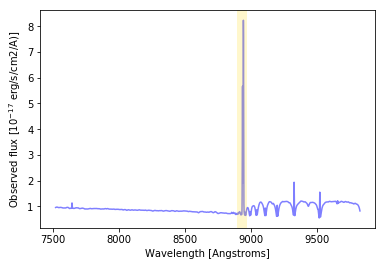

In [431]:
pl.plot(wave, fflux[0,:], c='b',    alpha=0.5)

pl.axvline(3727. * (1. + meta['REDSHIFT'][0]), c='gold', alpha=0.2, lw=10.)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [$10^{-17}$ erg/s/cm2/A)]')

In [432]:
uflux = fflux * fluxcalib   # Uncalibrated flux [counts/Angstrom] 

Text(0, 0.5, 'Observed flux [Counts/A)]')

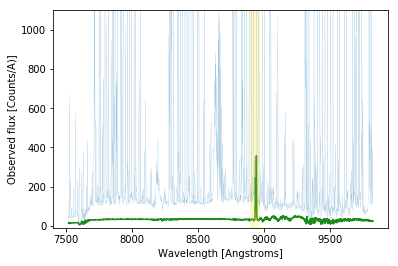

In [433]:
pl.plot(wave, uflux[0,:].T, c='green', alpha=0.9)

pl.plot(skies[camera]['WAVELENGTH'][:], skies[camera]['SKY'][0, :].T, alpha=1.0, lw=0.1)

pl.axvline(3727. * (1. + meta['REDSHIFT'][0]), c='gold', alpha=0.2, lw=10.)

pl.ylim(-10., 1100.)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [Counts/A)]')

## Calculate 'templateSNR' for an ensemble of DESI-like targets

In [442]:
sky_flux = skies[camera]['SKY'][0, :].T

In [443]:
meta['TEMPLATESNR'] = np.zeros_like(meta['REDSHIFT'])

for i, template_flux in enumerate(fflux):
    meta['TEMPLATESNR'][i] = templateSNR(template_flux, sky_flux[0], fluxcalib[0])
    
    print('Template SNR for the {} band is {}.]'.format(camera, meta['TEMPLATESNR'][i]))

Template SNR for the z band is 4186.4345703125.]
Template SNR for the z band is 1162.79638671875.]
Template SNR for the z band is 551.5596923828125.]
Template SNR for the z band is 825.501220703125.]
Template SNR for the z band is 265.2255859375.]
Template SNR for the z band is 961.2539672851562.]
Template SNR for the z band is 5603.70947265625.]
Template SNR for the z band is 66.00599670410156.]
Template SNR for the z band is 2369.867431640625.]
Template SNR for the z band is 1159.997802734375.]


In [444]:
meta

TARGETID,OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MAG_G,MAG_R,MAG_Z,TEMPLATESNR
,,,,,,mag,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,
int64,str10,str10,int16,int64,float32,float32,str15,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,ELG,,1501,37978649,1.3973327,21.143538,decam2014-g,3.4880683,4.331747,7.5806108,14.664615,14.090468,21.143538,20.908342,20.30074,4186.4346
1,ELG,,5796,1531825680,0.91115135,21.053633,decam2014-g,3.7891946,4.2492356,9.476098,21.184353,14.82427,21.053633,20.929222,20.058426,1162.7964
2,ELG,,4833,1062122751,1.0242573,21.11597,decam2014-g,3.5777645,3.9406073,7.858354,27.88119,20.869534,21.11597,21.011091,20.261671,551.5597
3,ELG,,3384,3764169279,1.5762113,22.8048,decam2014-g,0.7552313,1.0821304,1.7585948,5.4686937,6.20978,22.8048,22.4143,21.887085,825.5012
4,ELG,,5748,1691890573,1.4741949,23.213535,decam2014-g,0.5183056,0.704265,1.3843595,3.2476637,3.133984,23.213535,22.88066,22.146877,265.2256
5,ELG,,4772,997461941,1.031699,21.503859,decam2014-g,2.5029755,2.7795439,6.6488905,15.906907,12.153696,21.503859,21.390066,20.443127,961.25397
6,ELG,,2607,1469546315,0.6990802,21.490032,decam2014-g,2.5350535,3.9882565,8.58287,21.133049,13.112067,21.490032,20.998043,20.165918,5603.7095
7,ELG,,3837,924121918,1.5292765,21.820658,decam2014-g,1.8695493,2.0828574,2.8105333,6.825107,7.128939,21.820658,21.703352,21.378029,66.006


##  Post-process spectra post redrock, calculate templateSNR for the redrock best-fit template.

First, run redshift fitting. 

In [384]:
# https://github.com/desihub/desisim/blob/c64ad6c14f36409833ad8616cb8ce180b1af54c1/py/desisim/scripts/quickspectra.py#L248

In [410]:
spec = Spectra([camera], {camera: wave}, {camera: fflux}, {camera: flux_ivar}, 
               resolution_data={camera: res}, 
               mask={camera: mask}, 
               fibermap=fibermap, 
               meta=None,
               single=False)

In [475]:
desispec.io.write_spectra(os.environ['RESULTS'] + '/spec_test.fits', spec)  

'/global/scratch/mjwilson/spec_test.fits'

In [412]:
# https://github.com/desihub/tutorials/blob/master/simulating-desi-spectra.ipynb
zbest_file = os.path.join(os.environ['RESULTS'], 'test-zbest.fits')
zbest_file

'/global/scratch/mjwilson/test-zbest.fits'

In [413]:
cmd  = 'rrdesi {} --zbest {}'.format(os.environ['RESULTS'] + '/spec_test.fits', zbest_file)
srun = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
cmd  = '{} {} --mp 32'.format(srun, cmd)

print(cmd)

srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive rrdesi /global/scratch/mjwilson/spec_test.fits --zbest /global/scratch/mjwilson/test-zbest.fits --mp 32


Run on Cori Linux.  Finished?  Get the results.

In [476]:
zbest = Table.read(zbest_file, 'ZBEST')

In [477]:
zbest

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32
0,22.580081939697266,653.0876369931988 .. 6.37568758664233,1.3100869702177393,8.935011994166372e-06,0,2824,GALAXY,,10,2045.5821437835693,0,0
1,0.013298578560352325,43.12104837085008 .. -1.5108435448653719,0.8230366115658144,0.00010897921340766428,4,2824,GALAXY,,10,6.702164076268673,0,0
2,-0.00795450434088707,38.11455486767964 .. -1.4692348064930858,1.2281861099328213,0.0003424531986663416,1028,2824,GALAXY,,10,3.3046575833577663,0,0
3,2.5816218852996826,197.52951261674428 .. -9.890955349036696,1.046448947286915,2.854876922255824e-05,0,2824,GALAXY,,10,454.6912048757076,0,0
4,0.05220744013786316,88.60492928685976 .. -1.426798932314001,1.3435528176830518,0.0003021439294831344,0,2824,GALAXY,,10,9.584243047982454,0,0
5,0.09166119992733002,249.2181060045753 .. 4.701102916107816,0.6056865549147086,0.00011787602616745535,0,2824,GALAXY,,10,16.530208059120923,0,0
6,0.024365562945604324,48.015515409492096 .. -0.5698022286219572,1.3425152967433178,0.0002767394375020456,4,2824,GALAXY,,10,2.3092080084607005,0,0
7,2.0550081729888916,504.399757282469 .. 6.483042340220722,1.446052038444662,3.2132671850207165e-05,0,2824,GALAXY,,10,258.90633994340897,0,0
8,0.011965177953243256,99.01840175390069 .. 1.5474871552137806,1.2515139360852061,0.00021295196321123288,0,2824,GALAXY,,10,16.26281007193029,0,0


In [480]:
meta

TARGETID,OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MAG_G,MAG_R,MAG_Z,TEMPLATESNR
,,,,,,mag,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,
int64,str10,str10,int16,int64,float32,float32,str15,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,ELG,,1501,37978649,1.3973327,21.143538,decam2014-g,3.4880683,4.331747,7.5806108,14.664615,14.090468,21.143538,20.908342,20.30074,4186.4346
1,ELG,,5796,1531825680,0.91115135,21.053633,decam2014-g,3.7891946,4.2492356,9.476098,21.184353,14.82427,21.053633,20.929222,20.058426,1162.7964
2,ELG,,4833,1062122751,1.0242573,21.11597,decam2014-g,3.5777645,3.9406073,7.858354,27.88119,20.869534,21.11597,21.011091,20.261671,551.5597
3,ELG,,3384,3764169279,1.5762113,22.8048,decam2014-g,0.7552313,1.0821304,1.7585948,5.4686937,6.20978,22.8048,22.4143,21.887085,825.5012
4,ELG,,5748,1691890573,1.4741949,23.213535,decam2014-g,0.5183056,0.704265,1.3843595,3.2476637,3.133984,23.213535,22.88066,22.146877,265.2256
5,ELG,,4772,997461941,1.031699,21.503859,decam2014-g,2.5029755,2.7795439,6.6488905,15.906907,12.153696,21.503859,21.390066,20.443127,961.25397
6,ELG,,2607,1469546315,0.6990802,21.490032,decam2014-g,2.5350535,3.9882565,8.58287,21.133049,13.112067,21.490032,20.998043,20.165918,5603.7095
7,ELG,,3837,924121918,1.5292765,21.820658,decam2014-g,1.8695493,2.0828574,2.8105333,6.825107,7.128939,21.820658,21.703352,21.378029,66.006


Text(0, 0.5, 'REDROCK REDSHIFT')

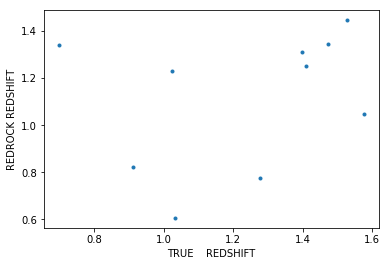

In [481]:
pl.plot(meta['REDSHIFT'], zbest['Z'], marker='.', lw=0.0)

pl.xlabel('TRUE    REDSHIFT')
pl.ylabel('REDROCK REDSHIFT')

Text(0, 0.5, '$\\log_{10}|\\Delta \\chi^2|$')

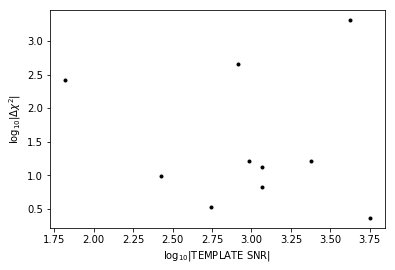

In [482]:
pl.plot(np.log10(meta['TEMPLATESNR']), np.log10(zbest['DELTACHI2']), marker='.', lw=0.0, c='k')

pl.xlabel('$\log_{10}$|TEMPLATE SNR|')
pl.ylabel('$\log_{10}|\Delta \chi^2|$')

In [458]:
# Import redrock templates
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/scratch/mjwilson/miniconda3/envs/desi/code/redrock-templates
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [483]:
rr_z     = zbest['Z'][0]

spectype = zbest['SPECTYPE'][0].strip()
subtype  = zbest['SUBTYPE'][0].strip()

fulltype = (spectype, subtype)
ncoeff   = templates[fulltype].flux.shape[0]

coeff    = zbest['COEFF'][0][0:ncoeff]

In [484]:
meta['REDSHIFT'][0], zbest['Z'][0]

(1.3973327, 1.3100869702177393)

In [485]:
rr_z, fulltype

(1.3100869702177393, ('GALAXY', ''))

In [486]:
tflux    = templates[fulltype].flux.T.dot(coeff)
twave    = templates[fulltype].wave * (1. + rr_z)

In [487]:
R        = Resolution(res[0])
txflux   = R.dot(resample_flux(wave, twave, tflux))

Text(0, 0.5, 'Observed flux [$10^{-17}$ erg/s/cm2/A)]')

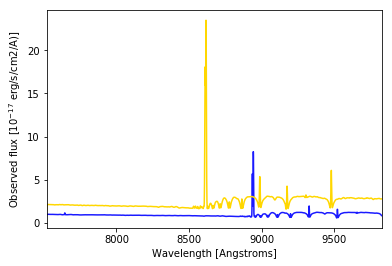

In [488]:
pl.plot(wave, fflux[0,:].T,  c='blue', alpha=0.9)
pl.plot(wave, txflux,        c='gold', alpha=1.0)

pl.xlim(wave[0], wave[-1])

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [$10^{-17}$ erg/s/cm2/A)]')

In [490]:
print('Template SNR for the {} band is {}.]'.format(camera, templateSNR(fflux[0,:], sky_flux[0], fluxcalib[0])))

Template SNR for the z band is 4186.434542978441.]


In [491]:
print('RRTemplate SNR for the {} band is {}.]'.format(camera, templateSNR(txflux, sky_flux[0], fluxcalib[0])))

RRTemplate SNR for the z band is 61176.32170418853.]


##  Rad. weights

_Each tile, each fiber, a redshift efficiency as a function of redshift and target magnitude, per target class. This could be
for instance in the form of fits images in 3D (fiber x redshift x magnitude), with one HDU per target class, and one fits
file per tile_

In [511]:
hdr             = fits.open(specpath)[0].header

hdr['EXTNAME']  = 'RADWEIGHT'

primary         = fits.PrimaryHDU(header=hdr)

# LRG
lrg_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='LRG')

# ELG
elg_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='ELG')

# QSO
qso_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='QSO')

# List
all_hdus        = fits.HDUList([primary, lrg_radweight, elg_radweight, qso_radweight])

all_hdus.writeto('/global/cscratch1/sd/mjwilson/desi/radweights/lss_radweights.fits', overwrite=True)

In [512]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2881                                                  
NAXIS2  =                  500                                                  
EXTEND  =                    T                                                  
EXTNAME = 'RADWEIGHT'                                                           
OBSERVAT= 'KPNO    '           / Observatory name                               
OBS-LAT = '31.96403'           / [deg] Observatory latitude                     
OBS-LONG= '-111.59989'         / [deg] Observatory east longitude               
OBS-ELEV=                2097. / [m] Observatory elevation                      
TELESCOP= 'KPNO 4.0-m telescope' / Telescope name                               
INSTRUME= 'DESI    '        

# Appendix A:  Fiberloss correction on Flux Calibration Vector

In [80]:
# https://github.com/desihub/desispec/blob/6c9810df3929b8518d49bad14356d35137d25a89/py/desispec/fluxcalibration.py#L809

In [81]:
from desimodel.io import load_desiparams, load_fiberpos, load_platescale, load_tiles, load_deviceloc

In [82]:
def fiber_area_arcsec2(x, y):
  params       = load_desiparams()

  fiber_dia    = params['fibers']['diameter_um']
    
  x            = np.asarray(x)
  y            = np.asarray(y)

  r            = np.sqrt(x**2 + y**2)

  #- Platescales in um/arcsec
  ps           = load_platescale()

  # ps['radius'] in mm.
  radial_scale = np.interp(r, ps['radius'], ps['radial_platescale'])
  az_scale     = np.interp(r, ps['radius'], ps['az_platescale'])
 
  #- radial and azimuthal fiber radii in arcsec
  rr           = 0.5 * fiber_dia / radial_scale
  raz          = 0.5 * fiber_dia / az_scale

  fiber_area = (np.pi * rr * raz)

  return rr, raz, fiber_area 

In [83]:
fiber_area_arcsec2(0.0, 0.0)

(0.7927738217452752, 0.7927738209229515, 1.9744606092121348)

In [84]:
def moffatt(r, fwhm, beta=3.5):
  ##  Apparent radial profile of star-light due to buffeting by the atmosphere.  
  ##  Sec. 4 of https://iopscience.iop.org/article/10.1086/675808/pdf;  [arcsecond].                                                                                                                                                         
  alpha    = fwhm / 2. / (2.**(1./beta) - 1.)**0.5

  return  (2. * (beta - 1.) / alpha / alpha) * (1. + (r/alpha)**2.)**-beta

In [85]:
fwhm       = 2.0
dr         = 0.01

rs         = np.arange(0.0, 15., dr)  ## [arcseconds].        
ms         = moffatt(rs, fwhm)

In [86]:
theta      = 0.7927738217452752

(-0.1, 6.0)

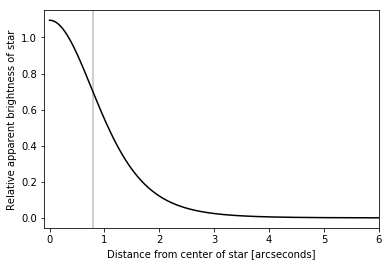

In [87]:
pl.axvline(theta, alpha=0.25, c='k')

pl.plot(rs, ms, c='k')
pl.xlabel('Distance from center of star [arcseconds]')
pl.ylabel('Relative apparent brightness of star')
pl.xlim(left=-0.1, right=6.0)

Text(0, 0.5, 'FIBER FRAC.')

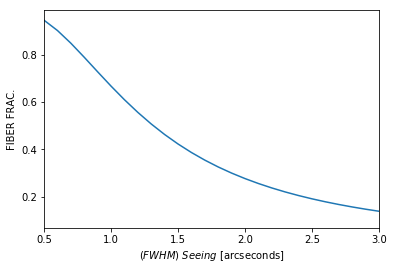

In [88]:
# A range of full-width @ half max. values for the seeing.  
fwhms      = np.arange(0.5, 3.5, 0.1)

# Find the index in our distance grid closest to the size of a fiber. 
indx       = np.abs(rs - theta).argmin()

# A list to collect the fraction of light down a fiber for each value of the seeing. 
fiberfracs = []

# Loop over the seeing values. 
for i, fwhm in enumerate(fwhms):
  # Work out the radial profile of the star.
  ms       = moffatt(rs, fwhm)
  
  # Integrate this to get the total light within a radius
  Is       = 2. * np.pi * dr * np.cumsum(rs * ms)

  # Calculate the fiber fraction for each r value we as for. 
  ffrac    = Is / Is[-1]
  
  # Save the fiber fraction for the radius corresponding to the fiber size. 
  fiberfracs.append(ffrac[indx])

fiberfracs = np.array(fiberfracs)

pl.plot(fwhms, fiberfracs)

pl.xlim(0.5, 3.0)

pl.xlabel(r'$(FWHM) \ Seeing \ [{\rm arcseconds}]$')
pl.ylabel(r'FIBER FRAC.')

## Done.